In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
import numpy as np
import bidi.algorithm
import arabic_reshaper

In [17]:
fpath = '/media/sf_VBox_Shared/Arabic/Analyses/topicmodelling/'

In [18]:
document_topics = pd.read_csv(os.path.join(fpath, 'document_topics_10.csv'), index_col=0).sort_index()
df_topics = pd.read_csv(os.path.join(fpath, 'topics_10.csv'), index_col=0)
metadata = pd.read_csv(os.path.join(fpath, 'metadata.csv'), index_col=0)

In [19]:
topic_names = df_topics['0'] +' '+ df_topics['1'] +' '+ df_topics['3']

In [20]:
def split_fname(fname):
    splitted = fname.split('-')
    bookname = splitted[0]
    if len(splitted)>1:
        chapter = int(splitted[-1].split('.')[0])
    else:
        chapter = 0
    return (bookname, chapter)
ind = pd.MultiIndex.from_tuples(document_topics.index.map(split_fname))
document_topics = document_topics.set_index(ind)

In [21]:
document_topics.head()

0         1         2         3         4  \
0179MalikIbnAnas.Muwatta 0  0.612438  0.000265  0.000265  0.000265  0.000265   
                         1  0.854471  0.001961  0.001962  0.001961  0.001961   
                         2  0.452199  0.001818  0.001818  0.001818  0.001819   
                         3  0.543650  0.000746  0.000746  0.000746  0.000747   
                         4  0.879009  0.000369  0.000369  0.000369  0.000369   

                                   5         6         7         8         9  
0179MalikIbnAnas.Muwatta 0  0.000265  0.000265  0.385445  0.000265  0.000265  
                         1  0.001962  0.001961  0.129838  0.001961  0.001961  
                         2  0.001818  0.001819  0.533253  0.001818  0.001818  
                         3  0.000746  0.000746  0.450378  0.000746  0.000747  
                         4  0.029043  0.000369  0.089364  0.000369  0.000369

In [22]:
new_ind = []
book_names = sorted(ind.levels[0])
for book in book_names:
    new_ind.extend(list(range(len(document_topics.loc[book]))))
new_ind = pd.MultiIndex.from_tuples(zip(ind.get_level_values(0), new_ind))

In [23]:
largest_topics = document_topics.idxmax(axis=1)
#largest_topics.index = new_ind
largest_topics = largest_topics.reset_index()
largest_topics.columns = ['book', 'chapter', 'topic']
largest_topics['chapter']
book_dict = {b: i for i,b in enumerate(book_names)}

In [24]:
largest_topics.head()

,book,chapter,topic
0,0179MalikIbnAnas.Muwatta,0,0
1,0179MalikIbnAnas.Muwatta,1,0
2,0179MalikIbnAnas.Muwatta,2,7
3,0179MalikIbnAnas.Muwatta,3,0
4,0179MalikIbnAnas.Muwatta,4,0


In [25]:
color_list = sns.color_palette(n_colors=len(topic_names))

In [26]:
import matplotlib.colors

def style_row(row):
    topic_id = int(row.name)
    color = matplotlib.colors.to_hex(color_list[topic_id])
    attr = 'background-color: {}'.format(color)
    return [attr for v in  row]
df_topics.style.apply(style_row, axis=1)

,0,1,2,3,4,5,6,7,8,9
0,قطع,قوم,يود,ثبت,حقق,حكم,قضي,قرر,دعا,شهد
1,عبر,علم,ذكر,خبر,خلف,عرف,ظهر,غور,سلم,عدم
2,خلف,غور,طهر,قوم,سلم,أمم,ركع,غسل,سجد,صلي
3,شرط,قوم,عقد,ملك,ثمن,رهن,قبض,جوز,شري,بيع
4,قوم,نصف,ولد,كتب,موت,قسم,وصي,عتق,أبن,ثلث
5,فلي,جور,قوم,زكي,جوز,أخذ,مول,عمل,أجر,ملك
6,ملك,دخل,ولد,مرأ,ثلث,وطأ,فلي,نكح,زوج,طلق
7,غور,وجب,حلل,جزأ,كفر,حوج,يوم,أكل,صوم,حرم
8,وبأ,فلي,صحي,الخ,خلف,شرح,ظهر,ذكر,غور,اه
9,روي,عمر,نبأ,حمد,فى,رسل,أبن,صلي,حدث,سلم


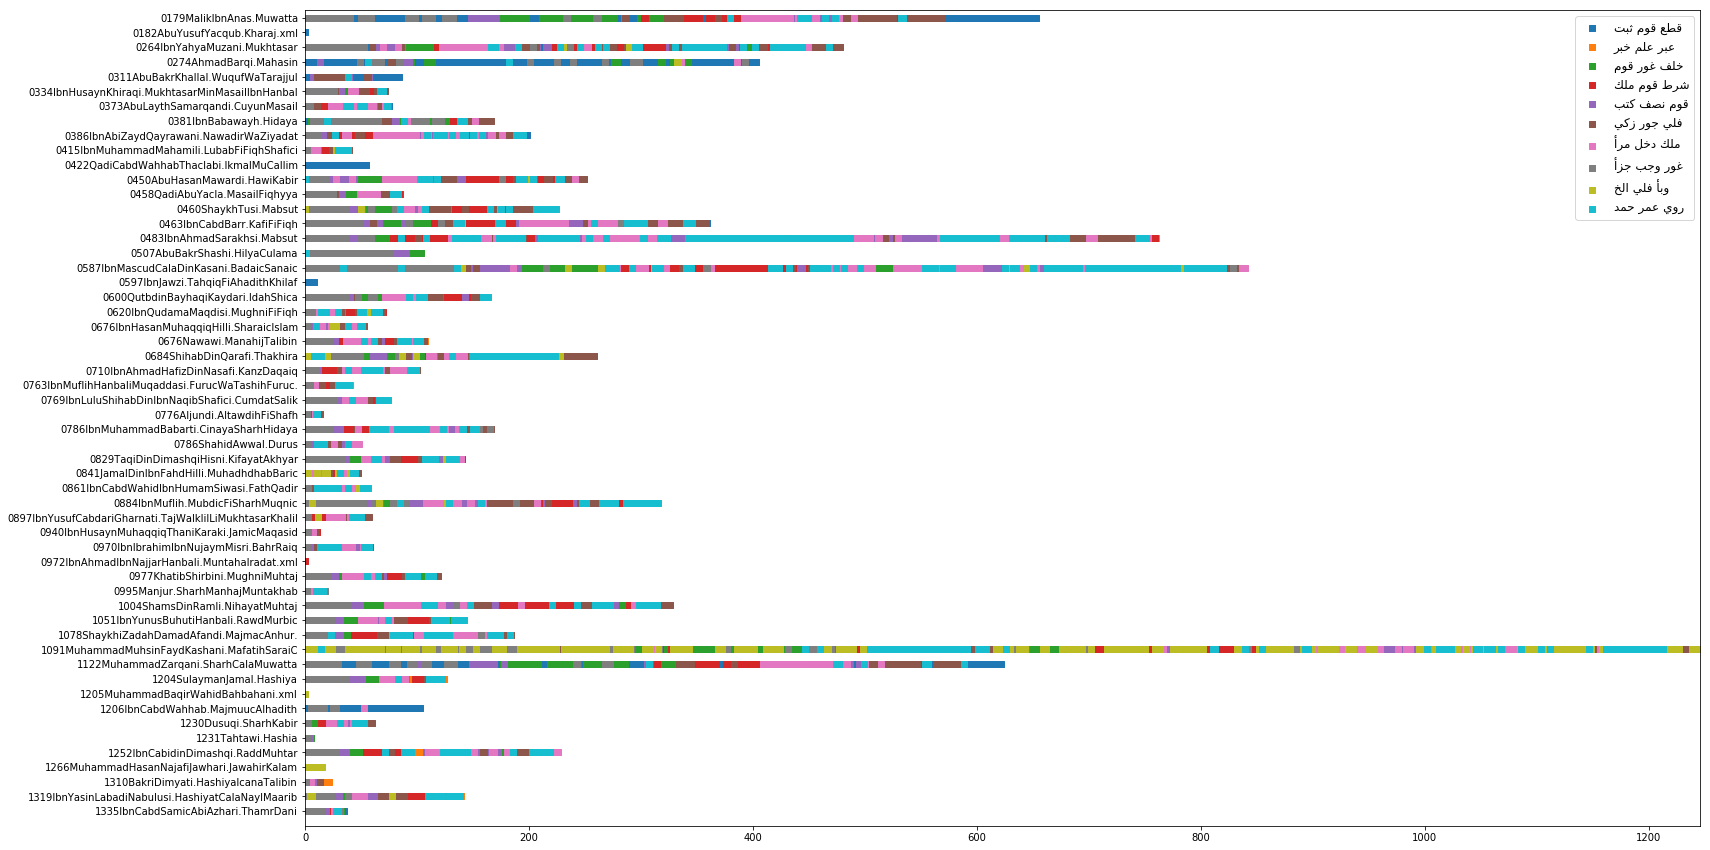

In [27]:
plt.figure(figsize=(25,15))
ax = plt.gca()
for topic in range(len(topic_names)):
    topic_name = topic_names[topic]
    largest_topics_sub = largest_topics[largest_topics['topic']==str(topic)]
    color = color_list[topic] 
    y = [book_dict[s] for s in largest_topics_sub['book']]
    x = largest_topics_sub['chapter']
    ax.scatter(x,y, marker='s', edgecolors=None, c=np.array((color,)), 
               label=bidi.algorithm.get_display(arabic_reshaper.reshape(topic_name)))
ax.set_yticks(np.arange(len(book_dict)))
ax.set_yticklabels(book_names)
ax.set_xlim(0, largest_topics['chapter'].max())
ax.set_ylim(-0.5, len(book_names))
plt.legend(fontsize='large')
ax.invert_yaxis()
plt.show()

In [14]:
metadata.columns

Index(['All_tokens_per-century', 'AuthorAKA', 'AuthorBORNC', 'AuthorBORNH',
       'AuthorDIEDC', 'AuthorDIEDH', 'AuthorNAME', 'Author_Geographical_Area',
       'BookSUBJ', 'BookTITLE', 'BookURI', 'BookVOLS', 'Century',
       'ChapterTitle', 'Number_of_tokens', 'Tagging', 'VolumeTitle',
       'filename'],
      dtype='object')